In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import linecache

In [2]:
# set data path
basepath = "/home/emily/Desktop/isamoa_data/"
path = basepath + "good3_sb32n16t_d26min66_irmfit_1458883"

jobid = path[-7:]
filename = path + '/' + jobid + '.log'
print(filename)

/home/emily/Desktop/isamoa_data/good3_sb32n16t_d26min66_irmfit_1458883/1458883.log


# Process data

In [13]:
phase_stats_markers = []

nranks = []
ncells = []
nelaps = []

impi_init = []
impi_probe = []
impi_begin = []
impi_commit = []
impi_adapt = []

####################
# impi exec times
####################

f = open(filename, 'r')
for i, line in enumerate(f,1):
    
    # find all "phase statistics" line numbers
    if "Phase statistics:" in line:
        phase_stats_markers = phase_stats_markers + [i]
        
    # Get nranks & ncells
    if ">>>" in line:
        line = line.split()
        try:
            ranks = int(line[-1])
            cells = int(line[-3][:-1])
            elaps = float(line[-5][:-1])
        except:
            pass
        else: 
            nranks = nranks + [ranks]
            nelaps = nelaps + [elaps]
            ncells = ncells + [cells * ranks]
            
    # Get MPI_Adapt_init time
    if "init_adapt" in line:
        line = line.split()
        idx = line.index("init_adapt")
        try:
            t = float(line[idx+1])
        except:
            pass
        else:
            impi_init = impi_init + [t]

    # Get MPI_Probe_adapt time
    if "probe_adapt" in line:
        line = line.split()
        idx = line.index("probe_adapt")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_probe = impi_probe + [time]
            
    # Get MPI_Comm_adapt_begin time
    if "adapt_begin" in line:
        line = line.split()
        idx = line.index("adapt_begin")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_begin = impi_begin + [time]

    # Get MPI_Comm_adapt_commit time
    if "adapt_commit" in line:
        line = line.split()
        idx = line.index("adapt_commit")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_commit = impi_commit + [time]

    # Get adaption time
    if "Total adaption time" in line:
        line = line.split()
        idx = line.index("=")
        try:
            time = float(line[idx+1])
        except:
            pass
        else:
            impi_adapt = impi_adapt + [time]            
f.close()


#####################
# Phase statistics:
#
# Phase time = (Grid time + load balancing time + conformity time) / (# ranks)
#            = (time steps time + adaptions time + load balancing time + conformity time + others) / (# ranks)
#
# Grid = Time steps + Adaptions + Output + X
#
#####################

t_phase = 0.0
t_timesteps = 0.0
t_adaptions = 0.0 
t_conformity = 0.0
t_lb = 0.0
t_others = 0.0

#remove the initialization and displacement phases
phase_stats_markers = phase_stats_markers[2:]

for marker in phase_stats_markers:
    
    # ranks
    line = linecache.getline(filename, marker+2)
    larr = line.split()
    n_ranks = int(larr[-1])
    
    # Phase time
    line = linecache.getline(filename, marker+13)
    larr = line.split()
    idx = larr.index("time:")
    t_phase = t_phase + float(larr[idx+1]) 
    
    # Time step computation time
    line = linecache.getline(filename, marker+5)
    larr = line.split()
    idx = larr.index("time:")
    tsteps_time = float(larr[idx+1])/float(n_ranks)
    t_timesteps = t_timesteps + tsteps_time
    
    # Grid adaption time
    line = linecache.getline(filename, marker+6)
    larr = line.split()
    idx = larr.index("time:")
    adap_time = float(larr[idx+1])/float(n_ranks)
    t_adaptions = t_adaptions + adap_time
    
    # Grid conformity check time
    line = linecache.getline(filename, marker+6)
    larr = line.split()
    idx = larr.index("integrity:")
    comform_time = float(larr[idx+1])/float(n_ranks)  
    t_conformity = t_conformity + comform_time
    
    # Load balancing time
    line = linecache.getline(filename, marker+6)
    larr = line.split()
    idx = larr.index("balancing:")
    lb_time = float(larr[idx+1])/float(n_ranks)
    t_lb = t_lb + lb_time
    
    # Other misc. time
    line = linecache.getline(filename, marker+7)
    larr = line.split()
    idx = larr.index("time:")
    grid_time = float(larr[idx+1])/float(n_ranks)
    t_others = t_others + (grid_time - tsteps_time - adap_time)
    
print("Total tsnami phase time = {}".format(t_phase))
print("Total computation time = {}".format(t_timesteps))
print("Total grid adaptation time = {}".format(t_adaptions))
print("Total grid conformity check time = {}".format(t_conformity))
print("Total load balancing time = {}".format(t_lb))
print("Total others time = {}".format(t_others))
print("")
    
####################
# iMPI times
####################

# Only count completed resource adaptations
n = len(impi_adapt)
impi_begin = impi_begin[:n]
impi_commit = impi_commit[:n]

# Compute total
impi_init_sum = sum(impi_init)
impi_probe_sum = sum(impi_probe)
impi_begin_sum = sum(impi_begin)
impi_commit_sum = sum(impi_commit)
impi_distr_sum = sum(impi_adapt) - impi_begin_sum - impi_commit_sum
impi_total = impi_probe_sum + impi_begin_sum + impi_commit_sum + impi_distr_sum

# Print
print("Averge MPI_Init_adapt: {}".format(impi_init_sum/len(impi_init)))
print("Averge MPI_Probe_adapt: {}".format(impi_probe_sum/len(impi_probe)))
print("Averge MPI_Adapt_begin: {}".format(impi_begin_sum/n))
print("Averge MPI_Adapt_commit: {}".format(impi_commit_sum/n))
print("Averge Data migration: {}".format(impi_distr_sum/n))
print("")
print("Accumulative MPI_Init_adapt: {}".format(impi_init_sum))
print("Accumulative MPI_Probe_adapt: {}".format(impi_probe_sum))
print("Accumulative MPI_Adapt_begin: {}".format(impi_begin_sum))
print("Accumulative MPI_Adapt_commit: {}".format(impi_commit_sum))
print("Accumulative Data migration: {}".format(impi_distr_sum))
print("")
print("Total resource adaptation time: {}".format(impi_total))



Total tsnami phase time = 205.1298
Total computation time = 62.54481506696429
Total grid adaptation time = 50.485827027529766
Total grid conformity check time = 27.737947972470238
Total load balancing time = 45.26126569940476
Total others time = 1.8734840401785684

Averge MPI_Init_adapt: 0.039
Averge MPI_Probe_adapt: 0.0005730897740112993
Averge MPI_Adapt_begin: 2.775874915
Averge MPI_Adapt_commit: 0.10262674249999999
Averge Data migration: 0.01855104749999996

Accumulative MPI_Init_adapt: 0.039
Accumulative MPI_Probe_adapt: 0.10143688999999997
Accumulative MPI_Adapt_begin: 11.10349966
Accumulative MPI_Adapt_commit: 0.41050696999999997
Accumulative Data migration: 0.07420418999999984

Total resource adaptation time: 11.689647710000001


# # Cells vs. Exec Time

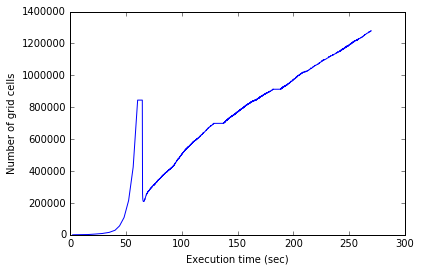

In [8]:
fig = plt.figure()
ax = fig.gca()
ax.plot(nelaps, ncells)
ax.set_xlabel("Execution time (sec)")
ax.set_ylabel("Number of grid cells")

fig.savefig(path+"/cells_vs_time.pdf",bbox_inches="tight")

# # Ranks vs. Exec Time

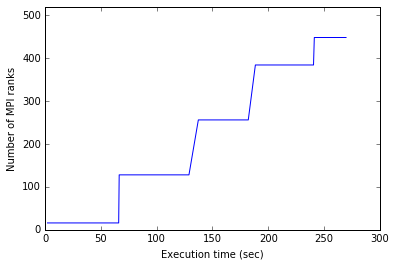

In [9]:
fig = plt.figure()
ax = fig.gca()
ax.plot(nelaps, nranks)
ax.set_xlabel("Execution time (sec)")
ax.set_ylabel("Number of MPI ranks")
ax.set_ylim(0, 520)

fig.savefig(path+"/ranks_vs_time.pdf",bbox_inches="tight")

# Component Runtime

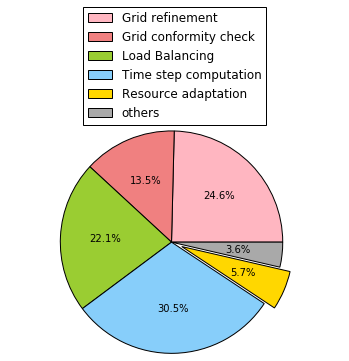

In [24]:
# t_phase = 0.0
# t_timesteps = 0.0
# t_adaptions = 0.0 
# t_conformity = 0.0
# t_lb = 0.0
# t_others = 0.0

t_others = t_phase - t_timesteps - t_adaptions - t_conformity - t_lb - impi_total

data = np.array([   
    ["Grid refinement", "lightpink", t_adaptions, 0], \
    ["Grid conformity check", "lightcoral", t_conformity, 0], \
    ["Load Balancing", "yellowgreen", t_lb, 0],\
    ["Time step computation", "lightskyblue", t_timesteps, 0],\
    ["Resource adaptation", "gold", impi_total, 0.1],\
    ["others", "darkgrey", t_others, 0]
])
labels = data[:,0].tolist()
colors = data[:,1].tolist()
sizes = [float(i) for i in (data[:,2]).tolist()]
explode = [float(i) for i in (data[:,3]).tolist()]

fig = plt.figure()
ax = fig.gca()
patches, texts, autotexts = ax.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', \
        shadow=False, startangle=0)
ax.axis('equal')
lgd = ax.legend(patches, labels, loc="lower center", bbox_to_anchor=(0.5, 1))
fig.savefig(path + "/pine_components.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


# Resource adaptation component view

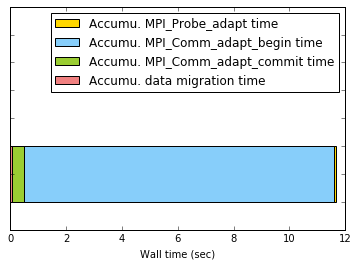

In [15]:
fig = plt.figure()
ax = fig.gca()
width = 1
# Layer 1. probe (bar tip)
data = impi_total
p1 = ax.barh(0, data, width, color='gold', align='center', label='Accumu. MPI_Probe_adapt time')

# Layer 2. begin 
data = data - impi_probe_sum
p2 = ax.barh(0, data, width, color='lightskyblue', align='center', label='Accumu. MPI_Comm_adapt_begin time')

# Layer 3. commit
data = data - impi_begin_sum
p3 = ax.barh(0, data, width, color='yellowgreen', align='center', label='Accumu. MPI_Comm_adapt_commit time')

# Layer 4. distribution (bar root)
data = data - impi_commit_sum
p4 = ax.barh(0, data, width, color='lightcoral', align='center', label='Accumu. data migration time')

ax.set_xlabel('Wall time (sec)')
ax.legend()
ax.set_ylim(-1, 3)
ax.tick_params(axis='y', which='both', bottom='off', top='off', labelbottom='off',\
               labelleft='off', labeltop='off', labelright='off')

# ax.text(1.4, -0.1, r'$3.22$', fontsize=12)
# ax.text(3.8, -0.1, r'$1.73$', fontsize=12)
# ax.text(5.2, -0.1, r'$1.02$', fontsize=12)
# ax.text(6.2, -0.1, r'$0.08$', fontsize=12)
# plt.plot([total_sum-0.1, total_sum+0.1], [0, 0], 'k-', lw=1)
# ax.text(2.8, 0.9, r'Total adaptation time = $6.06$', fontsize=12)
# plt.plot([total_sum, total_sum], [-1, 0.85], 'k-', lw=1)

fig.savefig(path + "/adaption_breakdown.pdf", bbox_inches='tight')